# Nonlinear Feedback Control using Neural Contraction Metrics ([NCMs](https://arxiv.org/abs/2006.04361))
This notebook delineates how to exploit Neural Contraction Metrics (NCMs) for the state feedback control of input-affine nonlinear dynamical systems.\
This software is released under the MIT License, Copyright (c) 2020 [Hiroyasu Tsukamoto](https://hirotsukamoto.com/). See [here](https://github.com/AstroHiro/ncm#license) for details.

## Required software
In addition to standard python packages like numpy, you need several other packages and software. The NCM class file [classncm.py](https://github.com/AstroHiro/ncm/blob/master/classncm.py) has been verified to work with CVXPY 1.1.1, Mosek 9.2.11, TensorFlow 2.2.0, and Keras 2.3.1.
* [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html) to see and edit codes
* [CVXPY](https://www.cvxpy.org/install/index.html) and [Mosek](https://docs.mosek.com/9.2/install/installation.html) to solve convex optimization problems
* [Keras](https://keras.io/about/) and [TensorFlow](https://www.tensorflow.org/install) to construct neural networks (Keras comes packaged with TensorFlow 2.0 as tensorflow.keras)

### [NCM Class](https://github.com/AstroHiro/ncm/wiki/Documentation) ([classncm.py](https://github.com/AstroHiro/ncm/blob/master/classncm.py))
This class provides several objects and methods for designing an NCM of a given nonliner dynamical system both for state estimation and feedback control. See the [NCM](https://arxiv.org/abs/2006.04361) and the [CV-STEM](https://arxiv.org/abs/2006.04359) pepers for more details. The documentation can be found [here](https://github.com/AstroHiro/ncm/wiki/Documentation).

In [1]:
import numpy as np
from classncm import NCM
np.random.seed(seed=8)

## Example: Balancing the Cart-Pole
We demonstrate how to use the NCM class for the optimal feedback control of the cart-pole inverted pendulum.
### Important parameters for NCM-based control
* dt : float\
discrete sampling period of CV-STEM
* dynamicsf = dynamicsf : function - ndarray (n, ) -> (n, )\
vector field of given dynamical system when u = 0, i.e. f of dx/dt = f(x)+g(x)u
* h_or_g = dynamicsg : function - ndarray (n, ) -> (n,m)\
actuation matrix g, i.e. g of dx/dt = f(x)+g(x)u
* xlims : ndarray - (2,n)\
lower and upper buonds of eash state
* alims : ndarray - (2, )\
lower and upper bound of contraction rate alpha

In [2]:
# enter your choice of CV-STEM sampling period
dt = 1
# specify upper and lower bounds of each state
xlims = np.array([-np.ones(4),np.ones(4)])*np.pi/3
# specify upper and lower bound of contraction rate (and we will find optimal alpha within this region)
alims = np.array([0.15,30])
# name your NCM
fname = "NCMcartpole"

M = 0.5 # mass or cart
m = 0.2 # mass of pole
l = 0.3 # length of pole
g = 9.8 # gravitational acceleration

def dynamicsf(x):
    """
    Enter input-affine nonlinear dynamical system of interest when u = 0
    (i.e. f of dx/dt = f(x)+g(x)u)

    Parameters
    ----------
    x : ndarray - (n, )
        current state

    Returns
    -------
    fx : ndarray - (n, )
        f(x) of dx/dt = f(x)+g(x)u

    """
    th = x[1]
    dthdt = x[3]
    f3 = m*np.sin(th)*(l*dthdt**2-g*np.cos(th))/(M+m*np.sin(th)**2)
    f4 = (-m*l*dthdt**2*np.sin(th)*np.cos(th)+(M+m)*g*np.sin(th))/l/(M+m*np.sin(th)**2)
    fx = np.array([x[2],x[3],f3,f4])
    return fx

def dynamicsg(x):
    """
    Enter nonlinear actuation matrix of input-affine nonlinear dynamical system 
    (i.e. g of dx/dt = f(x)+g(x)u)

    Parameters
    ----------
    x : ndarray - (n, )
        current state

    Returns
    -------
    gx : ndarray - (n, )
        g(x) of dx/dt = f(x)+g(x)u

    """
    th = x[1]
    g3 = 1/(M+m*np.sin(th)**2)
    g4 = -np.cos(th)/l/(M+m*np.sin(th)**2)
    gx = np.array([[0],[0],[g3],[g4]])
    return gx

# In this case, we select non-default upper bounds for external disturbances (d1_over=0.0015 and d2_over=1.5).
# Also, the step size for line search of alpha is also changed to non-default value (da = 0.01).
ncm = NCM(dt,dynamicsf,dynamicsg,xlims,alims,"con",fname,d1_over=0.0015,d2_over=1.5,da=0.01)

### [NCM train method](https://github.com/AstroHiro/ncm/wiki/NCM-methods:-train)
This method trains a neural network to be used for designing an NCM and returns a Keras neural network model. See [here](https://github.com/AstroHiro/ncm/wiki/NCM-methods:-train) for the explanation on this method.

In [3]:
# You can use ncm.train(iTrain = 0) instead when using pre-traind NCM models.
ncm.train()

============= LINE SEARCH OF OPTIMAL ALPHA =============
Optimal value: Jcv = 48.43 ( alpha = 0.150 )
Optimal value: Jcv = 48.12 ( alpha = 0.160 )
Optimal value: Jcv = 47.96 ( alpha = 0.170 )
Optimal value: Jcv = 47.93 ( alpha = 0.180 )
Optimal value: Jcv = 48.03 ( alpha = 0.190 )
Optimal contraction rate: alpha = 0.180
=========== LINE SEARCH OF OPTIMAL ALPHA END ===========


====== SAMPLING OF CONTRACTION METRICS BY CV-STEM ======
# sampled metrics:  0 ...
# sampled metrics:  100 ...
# sampled metrics:  200 ...
# sampled metrics:  300 ...
# sampled metrics:  400 ...
# sampled metrics:  500 ...
# sampled metrics:  600 ...
# sampled metrics:  700 ...
# sampled metrics:  800 ...
# sampled metrics:  900 ...
Optimal steady-state tracking error = 0.87
Directory models/optvals/NCMcartpole already exists
==== SAMPLING OF CONTRACTION METRICS BY CV-STEM END ====


=================== NCM CONSTRUCTION ===================
Model: "NCM"
____________________________________________________________

Epoch 89/10000
29/29 - 0s - loss: 1.0989e-04 - val_loss: 1.4775e-04
Epoch 90/10000
29/29 - 0s - loss: 1.4262e-04 - val_loss: 1.5027e-04
Epoch 91/10000
29/29 - 0s - loss: 1.2896e-04 - val_loss: 1.6210e-04
Epoch 92/10000
29/29 - 0s - loss: 1.1414e-04 - val_loss: 1.6307e-04
Epoch 93/10000
29/29 - 0s - loss: 1.3043e-04 - val_loss: 1.8275e-04
Epoch 94/10000
29/29 - 0s - loss: 1.2627e-04 - val_loss: 1.5617e-04
Epoch 95/10000
29/29 - 0s - loss: 1.1241e-04 - val_loss: 1.6865e-04
Epoch 96/10000
29/29 - 0s - loss: 1.2769e-04 - val_loss: 1.6622e-04
Epoch 97/10000
29/29 - 0s - loss: 1.1265e-04 - val_loss: 1.1978e-04
Epoch 98/10000
29/29 - 0s - loss: 1.1056e-04 - val_loss: 1.2606e-04
Epoch 99/10000
29/29 - 0s - loss: 1.0698e-04 - val_loss: 1.4846e-04
Epoch 100/10000
29/29 - 0s - loss: 1.0915e-04 - val_loss: 1.4266e-04
Epoch 101/10000
29/29 - 0s - loss: 9.7483e-05 - val_loss: 1.3595e-04
Epoch 102/10000
29/29 - 0s - loss: 1.1046e-04 - val_loss: 2.0704e-04
Epoch 103/10000
29/29 - 0s - loss: 1.1480e-04

### [NCM simulation method](https://github.com/AstroHiro/ncm/wiki/NCM-methods:-simulation)
This method performs NCM-based control of a given nonlinear dynamical system and generates figures of simulation results on state and tracking error histories. See [here](https://github.com/AstroHiro/ncm/wiki/NCM-methods:-simulation) for the explanation on this method.

====================== SIMULATIOM ======================
time step = 0.1
terminal time = 50
initial state = [ 0.2  0.6 -0.4  0.1]
==================== TRACKING ERROR ====================


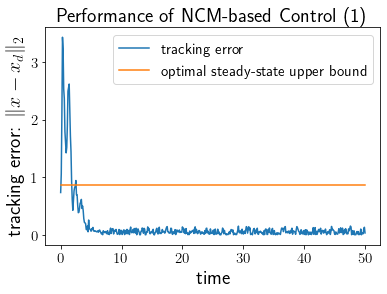

============= TRACKING ERROR OF EACH STATE =============


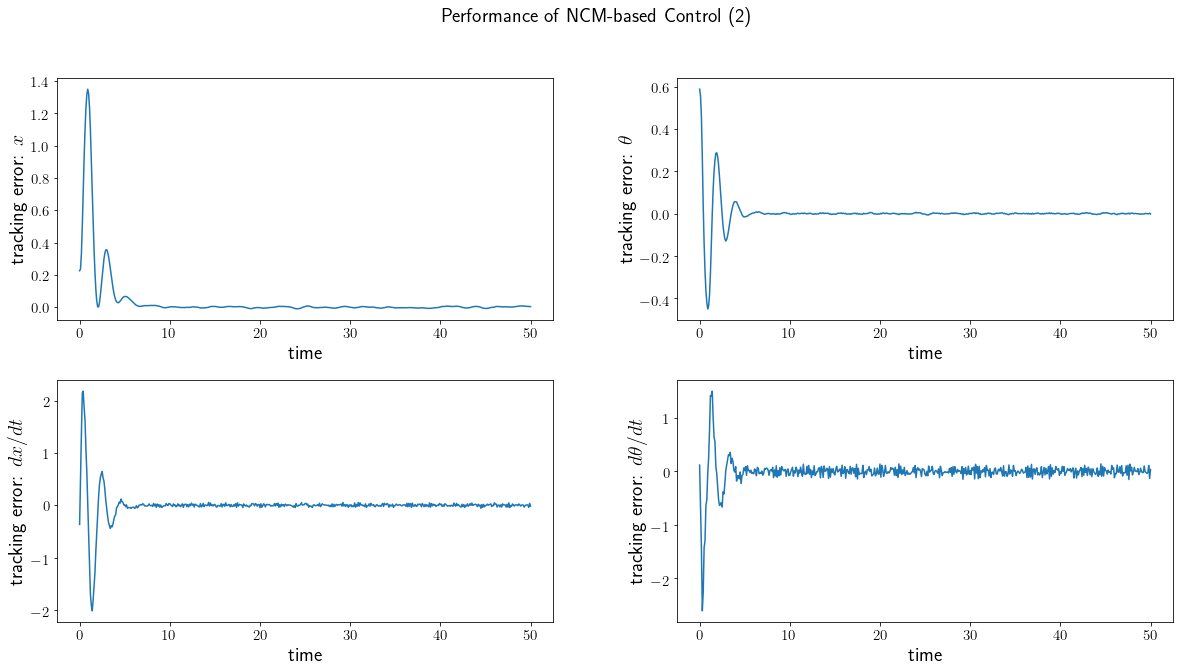

==================== SIMULATIOM END ====================


In [4]:
# simultion time step
dt = 0.1
# terminal time
tf = 50
# initial state
x0 = np.random.uniform(low=-np.ones(4)*np.pi/5,high=np.ones(4)*np.pi/5)
# simulation
snames = [r"$x$",r"$\theta$",r"$dx/dt$",r"$d\theta/dt$"]
this,xhis,_ = ncm.simulation(dt,tf,x0,dscale=1e2,xnames=snames,Ncol=2,FigSize=(20,10))

## It's Your Turn
Here is the list of things you need at least.
* nonlinear input-affine dynamical system
* state space of interest
* your guess of contraction rate (just put a small number if not sure)

In [ ]:
# enter your choice of CV-STEM sampling period
dt = 0.1
# specify upper and lower bounds of each state
xlims = np.array([-np.ones(3),np.ones(3)])*10.0
# specify upper and lower bound of contraction rate (and we will find optimal alpha within this region)
alims = np.array([2.0,30.0])
# name your NCM
filename = "yourNCMcontrol" 

def dynamics(x):
    """
    Enter nonlinear dynamical system of interest
        

    Parameters
    ----------
    x : ndarray - (n, )
        current state

    Returns
    -------
    dxdt : ndarray - (n, )
        time derivative of x given by dynamical system of interest

    """
    pass

def measurement(x):
    """
    Enter nonlinear measurement equation
        

    Parameters
    ----------
    x : ndarray - (n, )
        current state

    Returns
    -------
    y : ndarray - (n, )
        measurement, i.e. y of y = h(x) where h is measurement equation

    """
    pass

ncm = NCM(dt,dynamics,measurement,xlims,alims,"con",fname)

### [NCM train method](https://github.com/AstroHiro/ncm/wiki/NCM-methods:-train)
This method trains a neural network to be used for designing an NCM and returns a Keras neural network model. See [here](https://github.com/AstroHiro/ncm/wiki/NCM-methods:-train) for the explanation on this method.

In [ ]:
ncm.train()

### [NCM simulation method](https://github.com/AstroHiro/ncm/wiki/NCM-methods:-simulation)
This method performs NCM-based control of a given nonlinear dynamical system and generates figures of simulation results on state and tracking error histories. See [here](https://github.com/AstroHiro/ncm/wiki/NCM-methods:-simulation) for the explanation on this method.

In [ ]:
# simultion time step
dt = 0.1
# terminal time
tf = 50
# initial state
x0 = np.random.uniform(low=xlims[0,:],high=xlims[1,:])
# simulation
this,xhis,zhis = ncm.simulation(dt,tf,x0,Ncol=2,FigSize=(20,20))